## XGBoost - sensor stability - 2bins - 37/63

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")

In [2]:
df = pd.read_csv(f"../StabilityGasSensors_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sensor                   19 non-null     object 
 1   dopant_type              19 non-null     object 
 2   dopant_dose              19 non-null     float64
 3   calcination_temperature  19 non-null     object 
 4   BET_fresh                19 non-null     float64
 5   particle_size_fresh      19 non-null     float64
 6   BET_aged                 19 non-null     float64
 7   particle_size_aged       19 non-null     float64
 8   fresh_point              19 non-null     float64
 9   5th_day                  19 non-null     float64
 10  8th_day                  16 non-null     float64
 11  12th_day                 18 non-null     float64
 12  15th_day                 19 non-null     float64
 13  diff_0_5day              19 non-null     float64
 14  diff_0_5day_binned       19 

In [3]:
df["dopant_type"].unique()

array(['no dopant', 'Mo', 'Ce', 'Sm', 'Si'], dtype=object)

In [4]:
df["calcination_temperature"].unique()

array(['no calcination', '700', '850'], dtype=object)

In [5]:
target = "diff_5_15day_2bins"
representation = ["dopant_type", "dopant_dose", "calcination_temperature"]
random_state=42
train_size=10

In [6]:
encoder_dopant = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder_dopant.fit_transform(df[["dopant_type"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [7]:
df.columns

Index(['sensor', 'dopant_type', 'dopant_dose', 'calcination_temperature',
       'BET_fresh', 'particle_size_fresh', 'BET_aged', 'particle_size_aged',
       'fresh_point', '5th_day', '8th_day', '12th_day', '15th_day',
       'diff_0_5day', 'diff_0_5day_binned', 'diff_5_15day',
       'diff_5_15day_2bins', 'diff_5_15day_3bins', 'diff_5_15day_5050',
       'synthesis', 'synthesis_BET', 'dopant_type_Ce', 'dopant_type_Mo',
       'dopant_type_Si', 'dopant_type_Sm', 'dopant_type_no dopant'],
      dtype='object')

In [8]:
encoder_temp = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder_temp.fit_transform(df[["calcination_temperature"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [9]:
df.columns

Index(['sensor', 'dopant_type', 'dopant_dose', 'calcination_temperature',
       'BET_fresh', 'particle_size_fresh', 'BET_aged', 'particle_size_aged',
       'fresh_point', '5th_day', '8th_day', '12th_day', '15th_day',
       'diff_0_5day', 'diff_0_5day_binned', 'diff_5_15day',
       'diff_5_15day_2bins', 'diff_5_15day_3bins', 'diff_5_15day_5050',
       'synthesis', 'synthesis_BET', 'dopant_type_Ce', 'dopant_type_Mo',
       'dopant_type_Si', 'dopant_type_Sm', 'dopant_type_no dopant',
       'calcination_temperature_700', 'calcination_temperature_850',
       'calcination_temperature_no calcination'],
      dtype='object')

In [10]:
df.columns[21:30].to_list()

['dopant_type_Ce',
 'dopant_type_Mo',
 'dopant_type_Si',
 'dopant_type_Sm',
 'dopant_type_no dopant',
 'calcination_temperature_700',
 'calcination_temperature_850',
 'calcination_temperature_no calcination']

In [11]:
representation = ["dopant_dose"]
representation.extend(df.columns[21:30].to_list())

In [12]:
representation

['dopant_dose',
 'dopant_type_Ce',
 'dopant_type_Mo',
 'dopant_type_Si',
 'dopant_type_Sm',
 'dopant_type_no dopant',
 'calcination_temperature_700',
 'calcination_temperature_850',
 'calcination_temperature_no calcination']

In [13]:
def prepare_dataset_classification(
    df,
    target = "diff_5_15day_2bins",
    representation = representation,
    random_state=42,
    train_size=10
):
    df_train, df_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )

    print(len(df_train), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return X_train, y_train, X_test, y_test

In [14]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, random_state=42):
    clf = XGBClassifier(
        #learning_rate = 0.1,
        n_estimators=100, 
        random_state=random_state, 
        #early_stopping_rounds=10,
        objective="binary:logistic",
        #use_label_encoder=False, 
        eval_metric="logloss"
    )
    
    clf.fit(X_train, y_train, verbose=5)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [15]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 5

In [16]:
train_size = 5
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [17]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
5 14
random_state = 42
Accuracy: 0.6428571428571429
F1 macro: 0.391304347826087
F1 micro: 0.6428571428571429
F1 weighted: 0.5031055900621119
Kappa: 0.0
-------------Iteration 2/10
5 14
random_state = 43
Accuracy: 0.6428571428571429
F1 macro: 0.391304347826087
F1 micro: 0.6428571428571429
F1 weighted: 0.5031055900621119
Kappa: 0.0
-------------Iteration 3/10
5 14
random_state = 44
Accuracy: 0.6428571428571429
F1 macro: 0.391304347826087
F1 micro: 0.6428571428571429
F1 weighted: 0.5031055900621119
Kappa: 0.0
-------------Iteration 4/10
5 14
random_state = 45
Accuracy: 0.6428571428571429
F1 macro: 0.391304347826087
F1 micro: 0.6428571428571429
F1 weighted: 0.5031055900621119
Kappa: 0.0
-------------Iteration 5/10
5 14
random_state = 46
Accuracy: 0.6428571428571429
F1 macro: 0.391304347826087
F1 micro: 0.6428571428571429
F1 weighted: 0.5031055900621119
Kappa: 0.0
-------------Iteration 6/10
5 14
random_state = 47
Accuracy: 0.6428571428571429
F1 macro: 0.39130434

In [18]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 5
mean accuracy: 0.642857142857143 +/- 1.1102230246251565e-16
mean F1 macro: 0.391304347826087 +/- 0.0
mean F1 micro: 0.642857142857143 +/- 1.1102230246251565e-16
mean F1 weighted: 0.5031055900621119 +/- 0.0
mean Kappa: 0.0 +/- 0.0


In [19]:
compiled_res_5 = pd.DataFrame(metrics_dict())
compiled_res_5.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
1,5,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
2,5,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0


### training size = 8

In [20]:
train_size = 8
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [21]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
8 11
random_state = 42
Accuracy: 0.6363636363636364
F1 macro: 0.3888888888888889
F1 micro: 0.6363636363636364
F1 weighted: 0.494949494949495
Kappa: 0.0
-------------Iteration 2/10
8 11
random_state = 43
Accuracy: 0.6363636363636364
F1 macro: 0.3888888888888889
F1 micro: 0.6363636363636364
F1 weighted: 0.494949494949495
Kappa: 0.0
-------------Iteration 3/10
8 11
random_state = 44
Accuracy: 0.6363636363636364
F1 macro: 0.3888888888888889
F1 micro: 0.6363636363636364
F1 weighted: 0.494949494949495
Kappa: 0.0
-------------Iteration 4/10
8 11
random_state = 45
Accuracy: 0.6363636363636364
F1 macro: 0.3888888888888889
F1 micro: 0.6363636363636364
F1 weighted: 0.494949494949495
Kappa: 0.0
-------------Iteration 5/10
8 11
random_state = 46
Accuracy: 0.6363636363636364
F1 macro: 0.3888888888888889
F1 micro: 0.6363636363636364
F1 weighted: 0.494949494949495
Kappa: 0.0
-------------Iteration 6/10
8 11
random_state = 47
Accuracy: 0.6363636363636364
F1 macro: 0.38888888

In [22]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 8
mean accuracy: 0.6363636363636365 +/- 1.1102230246251565e-16
mean F1 macro: 0.3888888888888889 +/- 0.0
mean F1 micro: 0.6363636363636365 +/- 1.1102230246251565e-16
mean F1 weighted: 0.494949494949495 +/- 0.0
mean Kappa: 0.0 +/- 0.0


In [23]:
compiled_res_8 = pd.DataFrame(metrics_dict())
compiled_res_8.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,8,"[1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.636364,0.388889,0.636364,0.494949,0.0
1,8,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.636364,0.388889,0.636364,0.494949,0.0
2,8,"[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.636364,0.388889,0.636364,0.494949,0.0


### training size = 10

In [24]:
train_size = 10
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [25]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
10 9
random_state = 42
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333334
Kappa: 0.0
-------------Iteration 2/10
10 9
random_state = 43
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333334
Kappa: 0.0
-------------Iteration 3/10
10 9
random_state = 44
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333334
Kappa: 0.0
-------------Iteration 4/10
10 9
random_state = 45
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333334
Kappa: 0.0
-------------Iteration 5/10
10 9
random_state = 46
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333334
Kappa: 0.0
-------------Iteration 6/10
10 9
random_state = 47
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333334
Kappa: 0.0
----

In [26]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 10
mean accuracy: 0.6444444444444444 +/- 0.04444444444444442
mean F1 macro: 0.43 +/- 0.06000000000000001
mean F1 micro: 0.6444444444444444 +/- 0.04444444444444442
mean F1 weighted: 0.54 +/- 0.013333333333333287
mean Kappa: 0.02857142857142858 +/- 0.05714285714285716


In [27]:
compiled_res_10 = pd.DataFrame(metrics_dict())
compiled_res_10.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,10,"[0, 1, 1, 0, 1, 0, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",0.666667,0.4,0.666667,0.533333,0.0
1,10,"[1, 1, 0, 1, 1, 0, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",0.666667,0.4,0.666667,0.533333,0.0
2,10,"[1, 1, 1, 0, 1, 0, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",0.666667,0.4,0.666667,0.533333,0.0


### training size = 12

In [28]:
train_size = 12
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [29]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
12 7
random_state = 42
Accuracy: 0.5714285714285714
F1 macro: 0.36363636363636365
F1 micro: 0.5714285714285714
F1 weighted: 0.4155844155844156
Kappa: 0.0
-------------Iteration 2/10
12 7
random_state = 43
Accuracy: 0.5714285714285714
F1 macro: 0.36363636363636365
F1 micro: 0.5714285714285714
F1 weighted: 0.4155844155844156
Kappa: 0.0
-------------Iteration 3/10
12 7
random_state = 44
Accuracy: 0.5714285714285714
F1 macro: 0.36363636363636365
F1 micro: 0.5714285714285714
F1 weighted: 0.4155844155844156
Kappa: 0.0
-------------Iteration 4/10
12 7
random_state = 45
Accuracy: 0.5714285714285714
F1 macro: 0.36363636363636365
F1 micro: 0.5714285714285714
F1 weighted: 0.4155844155844156
Kappa: 0.0
-------------Iteration 5/10
12 7
random_state = 46
Accuracy: 0.5714285714285714
F1 macro: 0.36363636363636365
F1 micro: 0.5714285714285714
F1 weighted: 0.4155844155844156
Kappa: 0.0
-------------Iteration 6/10
12 7
random_state = 47
Accuracy: 0.5714285714285714
F1 macro: 

In [31]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 12
mean accuracy: 0.5571428571428572 +/- 0.04285714285714286
mean F1 macro: 0.37424242424242427 +/- 0.056322076564522594
mean F1 micro: 0.5571428571428572 +/- 0.04285714285714286
mean F1 weighted: 0.42199134199134203 +/- 0.04857166006843461
mean Kappa: -0.018577075098814212 +/- 0.08859487839031897


In [32]:
compiled_res_12 = pd.DataFrame(metrics_dict())
compiled_res_12.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,12,"[0, 1, 0, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1]",0.571429,0.363636,0.571429,0.415584,0.0
1,12,"[1, 1, 0, 1, 1, 0, 0]","[1, 1, 1, 1, 1, 1, 1]",0.571429,0.363636,0.571429,0.415584,0.0
2,12,"[1, 1, 1, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]",0.571429,0.363636,0.571429,0.415584,0.0


### training size = 13

In [33]:
train_size = 13
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [34]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
13 6
random_state = 42
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333333
Kappa: 0.0
-------------Iteration 2/10
13 6
random_state = 43
Accuracy: 0.6666666666666666
F1 macro: 0.625
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.25
-------------Iteration 3/10
13 6
random_state = 44
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333333
Kappa: 0.0
-------------Iteration 4/10
13 6
random_state = 45
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333333
Kappa: 0.0
-------------Iteration 5/10
13 6
random_state = 46
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333333
Kappa: 0.0
-------------Iteration 6/10
13 6
random_state = 47
Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333333
Kappa: 0.0
-

In [36]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 13
mean accuracy: 0.6166666666666667 +/- 0.07637626158259732
mean F1 macro: 0.4554761904761905 +/- 0.09466374432588179
mean F1 micro: 0.6166666666666667 +/- 0.07637626158259732
mean F1 weighted: 0.535873015873016 +/- 0.07416351365307346
mean Kappa: 0.05779220779220782 +/- 0.1547090697811819


In [37]:
compiled_res_13 = pd.DataFrame(metrics_dict())
compiled_res_13.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,13,"[0, 1, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1]",0.666667,0.400,0.666667,0.533333,0.00
1,13,"[1, 0, 1, 1, 1, 0]","[0, 1, 1, 1, 1, 0]",0.666667,0.625,0.666667,0.666667,0.25
2,13,"[1, 1, 1, 0, 1, 0]","[1, 1, 1, 1, 1, 1]",0.666667,0.400,0.666667,0.533333,0.00


### training size = 14

In [38]:
train_size = 14
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [39]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
14 5
random_state = 42
Accuracy: 0.6
F1 macro: 0.375
F1 micro: 0.6
F1 weighted: 0.45
Kappa: 0.0
-------------Iteration 2/10
14 5
random_state = 43
Accuracy: 0.6
F1 macro: 0.5833333333333333
F1 micro: 0.6
F1 weighted: 0.6
Kappa: 0.16666666666666663
-------------Iteration 3/10
14 5
random_state = 44
Accuracy: 0.6
F1 macro: 0.375
F1 micro: 0.6
F1 weighted: 0.45
Kappa: 0.0
-------------Iteration 4/10
14 5
random_state = 45
Accuracy: 0.6
F1 macro: 0.375
F1 micro: 0.6
F1 weighted: 0.45
Kappa: 0.0
-------------Iteration 5/10
14 5
random_state = 46
Accuracy: 0.6
F1 macro: 0.375
F1 micro: 0.6
F1 weighted: 0.45
Kappa: 0.0
-------------Iteration 6/10
14 5
random_state = 47
Accuracy: 0.6
F1 macro: 0.375
F1 micro: 0.6
F1 weighted: 0.45
Kappa: 0.0
-------------Iteration 7/10
14 5
random_state = 48
Accuracy: 0.4
F1 macro: 0.2857142857142857
F1 micro: 0.4
F1 weighted: 0.34285714285714286
Kappa: -0.36363636363636354
-------------Iteration 8/10
14 5
random_state = 49
Accuracy

In [40]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 14
mean accuracy: 0.5599999999999999 +/- 0.07999999999999999
mean F1 macro: 0.38940476190476186 +/- 0.07065744468770375
mean F1 micro: 0.5599999999999999 +/- 0.07999999999999999
mean F1 weighted: 0.4492857142857144 +/- 0.06039411378265133
mean Kappa: -0.035081585081585064 +/- 0.1309086115086952


In [41]:
compiled_res_14 = pd.DataFrame(metrics_dict())
compiled_res_14.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,14,"[0, 0, 1, 1, 1]","[1, 1, 1, 1, 1]",0.6,0.375000,0.6,0.45,0.000000
1,14,"[0, 1, 1, 1, 0]","[1, 0, 1, 1, 0]",0.6,0.583333,0.6,0.60,0.166667
2,14,"[1, 0, 1, 1, 0]","[1, 1, 1, 1, 1]",0.6,0.375000,0.6,0.45,0.000000


### training size = 15

In [42]:
train_size = 15
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [43]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
15 4
random_state = 42
Accuracy: 0.75
F1 macro: 0.42857142857142855
F1 micro: 0.75
F1 weighted: 0.6428571428571428
Kappa: 0.0
-------------Iteration 2/10
15 4
random_state = 43
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.5
Kappa: -0.33333333333333326
-------------Iteration 3/10
15 4
random_state = 44
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.5
Kappa: -0.33333333333333326
-------------Iteration 4/10
15 4
random_state = 45
Accuracy: 0.75
F1 macro: 0.42857142857142855
F1 micro: 0.75
F1 weighted: 0.6428571428571428
Kappa: 0.0
-------------Iteration 5/10
15 4
random_state = 46
Accuracy: 0.75
F1 macro: 0.42857142857142855
F1 micro: 0.75
F1 weighted: 0.6428571428571428
Kappa: 0.0
-------------Iteration 6/10
15 4
random_state = 47
Accuracy: 0.75
F1 macro: 0.42857142857142855
F1 micro: 0.75
F1 weighted: 0.6428571428571428
Kappa: 0.0
-------------Iteration 7/10
15 4
random_state = 48
Accuracy: 0.5
F1 macro: 0.5

In [44]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 15
mean accuracy: 0.625 +/- 0.125
mean F1 macro: 0.41428571428571426 +/- 0.05947617141331808
mean F1 micro: 0.625 +/- 0.125
mean F1 weighted: 0.5714285714285714 +/- 0.07142857142857138
mean Kappa: -0.059999999999999984 +/- 0.19425069712444615


In [45]:
compiled_res_15 = pd.DataFrame(metrics_dict())
compiled_res_15.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[1, 0, 1, 1]","[1, 1, 1, 1]",0.75,0.428571,0.75,0.642857,0.000000
1,15,"[1, 1, 1, 0]","[0, 1, 1, 1]",0.50,0.333333,0.50,0.500000,-0.333333
2,15,"[1, 0, 1, 1]","[1, 1, 0, 1]",0.50,0.333333,0.50,0.500000,-0.333333


In [46]:
compiled_res = pd.concat([
    compiled_res_5, 
    compiled_res_8,
    compiled_res_10,
    compiled_res_12,
    compiled_res_13,
    compiled_res_14,
    compiled_res_15
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

70


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
1,5,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
2,5,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
3,5,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
4,5,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0


In [47]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [90]:
compiled_res.to_csv("XGBoost_results_sensorStability_2bins_3763.csv", sep=",", index=False)

In [91]:
df = pd.read_csv("XGBoost_results_sensorStability_2bins_3763.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   70 non-null     int64  
 1   y_true       70 non-null     object 
 2   y_pred       70 non-null     object 
 3   accuracy     70 non-null     float64
 4   f1_macro     70 non-null     float64
 5   f1_micro     70 non-null     float64
 6   f1_weighted  70 non-null     float64
 7   kappa        70 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.5+ KB


In [92]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
1,5,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0
2,5,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.642857,0.391304,0.642857,0.503106,0.0


In [93]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
5           0.642857  0.000000  0.391304  0.000000  0.642857  0.000000   
8           0.636364  0.000000  0.388889  0.000000  0.636364  0.000000   
10          0.644444  0.014815  0.430000  0.020000  0.644444  0.014815   
12          0.557143  0.014286  0.374242  0.018774  0.557143  0.014286   
13          0.616667  0.025459  0.455476  0.031555  0.616667  0.025459   
14          0.560000  0.026667  0.389405  0.023552  0.560000  0.026667   
15          0.625000  0.041667  0.414286  0.019825  0.625000  0.041667   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
5             0.503106  0.000000  0.000000  0.000000  
8             0.494949  0.000000  0.000000  0.000000  
10            0.540000  0.004444  0.028571  0.019048  
12            0.421991  0.016191 -0.018577  0.029532  
13            0.535873  0.024721  0.057792  0.051570  
14            0.449286  0.020131 -0.035082  0.043636  
15            0.571429  0.023810 -0.060000  0.064750

In [94]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.2        0.8       ]
 [0.23333333 0.76666667]]
accuracy: 0.625


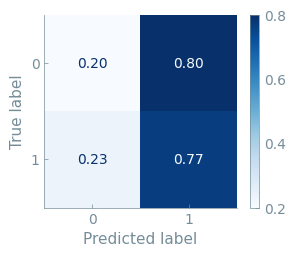

In [95]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_sensorStability_confusionMatrix_37_63_120ep_size15_XGBoost.pdf', bbox_inches='tight')